In [1]:
version = "v20251219"

"v20251219"

## load model and predict

In [2]:
using JLD2
using Lux
using LuxCore
using EasyHybrid
using Optimisers

jldfile = "/mnt/tupi/HybridModeling/EasyDensity.jl/model/best_model_03_hybridNN_config105_fold4.jld2"

function load_last_epoch_ps_st(jldfile)
    jldopen(jldfile, "r") do f
        g = f["HybridModel_SingleNNHybridModel"]
        epochs = sort(
            parse.(Int, replace.(keys(g), "epoch_" => ""))
        )
        last_epoch = "epoch_$(last(epochs))"
        ge = g[last_epoch]
        return ge
    end
end

hm = load_last_epoch_ps_st(jldfile);
ps = hm[1]
st = hm[2]

(st = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()), fixed = NamedTuple())

In [3]:
# prepare data
# load in preprocessed data to get predictors
datafile = "/mnt/tupi/HybridModeling/EasyDensity.jl/data/lucas_preprocessed_v20251125.csv"
oridf = CSV.read(datafile, DataFrame; normalizenames=true)
predictors = Symbol.(names(oridf))[18:end-6]; # CHECK EVERY TIME 

# get the overlaid data
df = CSV.read("production_preprocessed_$(version).csv", DataFrame)
x_test = to_keyedArray(Float32.(df[!, predictors]));

In [5]:
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

function SOCD_model(; SOCconc, CF, oBD, mBD)
    ϵ = 1e-7

    # invert transforms
    soct = (exp.(SOCconc ./ scalers[:SOCconc]) .- 1) ./ 1000
    soct = clamp.(soct, ϵ, Inf)
    
    cft = (exp.(CF ./ scalers[:CF]) .- 1) ./ 100
    cft = clamp.(cft, 0, 0.99)

    # compute BD safely
    som = 1.724f0 .* soct
    som = clamp.(som, 0, 1) # test!!!!!!!!
    
    denom = som .* mBD .+ (1f0 .- som) .* oBD
    # denom = clamp.(denom, ϵ, Inf)

    BD = (oBD .* mBD) ./ denom
    BD = clamp.(BD, ϵ, Inf)

    # SOCdensity
    SOCdensity = soct .* 1000 .* BD .* (1 .- cft)
    SOCdensity = clamp.(SOCdensity, 1, Inf)

    # scale
    SOCdensity = log.(SOCdensity) .* scalers[:SOCdensity]
    BD = BD .* scalers[:BD]

    return (; BD, SOCconc, CF, SOCdensity, oBD, mBD)
end

parameters = (
    SOCconc = (0.01f0, 0.0f0, 1.0f0),   # fraction
    CF      = (0.15f0, 0.0f0, 1.0f0),   # fraction,
    oBD     = (0.20f0, 0.05f0, 0.40f0),  # also NN learnt, g/cm3
    mBD     = (1.20f0, 0.75f0, 2.0f0),  # NN leanrt
)
neural_param_names = [:SOCconc, :CF, :mBD, :oBD]
forcing = Symbol[]
targets = [:BD, :SOCconc, :SOCdensity, :CF]   

hmb = constructHybridModel(
    predictors,
    forcing,
    targets,
    SOCD_model,
    parameters,
    neural_param_names,
    [];
    hidden_layers = [256, 128, 64, 32],
    activation = gelu,
    scale_nn_outputs = true,
    input_batchnorm = false,
    start_from_default = true
)

Neural Network:
    Chain(
        layer_1 = WrappedFunction(identity),
        layer_2 = Dense(362 => 256, gelu_tanh),       # 92_928 parameters
        layer_3 = Dense(256 => 128, gelu_tanh),       # 32_896 parameters
        layer_4 = Dense(128 => 64, gelu_tanh),        # 8_256 parameters
        layer_5 = Dense(64 => 32, gelu_tanh),         # 2_080 parameters
        layer_6 = Dense(32 => 4),                     # 132 parameters
    )         # Total: 136_292 parameters,
              #        plus 0 states.
Predictors: [:cropland_extent_glad_interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20240604, :ndvi_glad_landast_ard2_seasconv_m_yearly_p25_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127, :evi_glad_landsat_ard2_seasconv_m_30m_s_YYYY0901_YYYY1031_eu_epsg_3035_v20231127, :pft_grass_nat_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616, :pft_trees_bd_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_epsg_4326_v20230616, :pft_bare_esa_cci_lc_pc_300m_s_YYYY0101_YYYY1231_go_ep

In [6]:
# prediction
ŷ_test, _ = hmb(x_test, ps, st)
for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
    if hasproperty(ŷ_test, var)
        val = getproperty(ŷ_test, var)

        if val isa AbstractVector && length(val) == nrow(df)
            df[!, Symbol("pred_", var)] = val # per row

        elseif (val isa Number) || (val isa AbstractVector && length(val) == 1)
            df[!, Symbol("pred_", var)] = fill(Float32(val isa AbstractVector ? first(val) : val), nrow(df))
        end
    end
end
println(size(df))

(15600, 370)


Variable: pred_BD
  Valid count = 15600
  Min = 0.026450000394135715
  Max = 1.0579992704037264



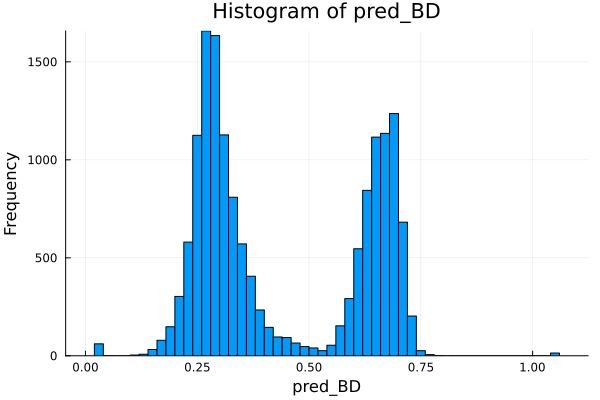

Variable: pred_SOCconc
  Valid count = 15600
  Min = 5.73e-43
  Max = 1.0



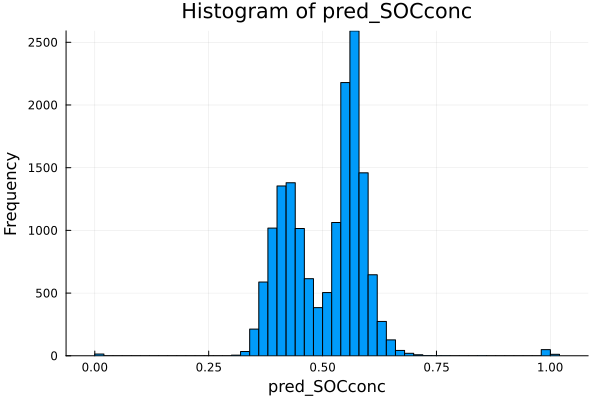

Variable: pred_CF
  Valid count = 15600
  Min = 4.4916146e-7
  Max = 1.0



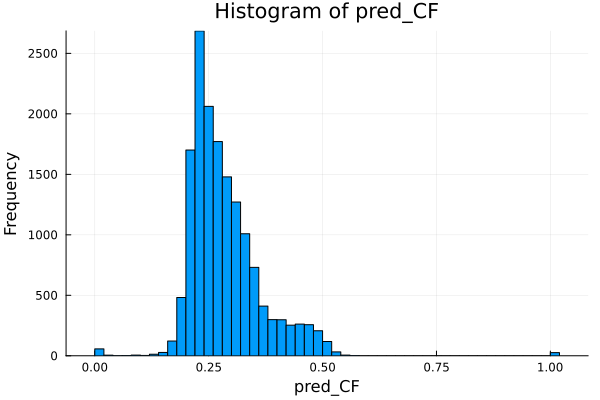

Variable: pred_SOCdensity
  Valid count = 15600
  Min = 0.0
  Max = 0.6736068370865161



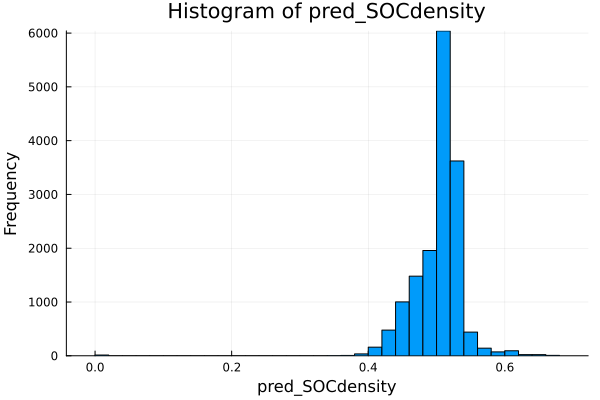

In [12]:
using Statistics
using Plots
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = df[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end

## save as tiff

In [28]:
using ArchGDAL
using Proj
const AG = ArchGDAL

function write_geotiff_from_grid(
    df, xs, ys, vcol, outfile;
    crs = "EPSG:3035",
    nodata = NaN32
)
    nx = length(xs)
    ny = length(ys)

    @assert nx * ny == nrow(df)

    # reshape values exactly as grid was constructed
    Z = reshape(Float32.(df[!, vcol]), ny, nx)

    # GeoTransform: (xmin, dx, 0, ymax, 0, -dy)
    gt = [
        first(xs), xs[2] - xs[1], 0.0,
        first(ys), 0.0, ys[2] - ys[1]
    ]

    AG.create(
        outfile;
        driver = AG.getdriver("GTiff"),
        width  = nx,
        height = ny,
        nbands = 1,
        dtype  = Float32
    ) do ds
        AG.write!(ds, Z, 1)
        AG.setgeotransform!(ds, gt)
        AG.setproj!(ds, crs)
        AG.setnodatavalue!(AG.getband(ds, 1), nodata)
    end
end

function make_grid_3035(bbox, res_m)
    # bbox = (xmin, ymin, xmax, ymax) in EPSG:3035

    xmin, ymin, xmax, ymax = bbox

    xs = collect(xmin:res_m:xmax)
    ys = collect(ymax:-res_m:ymin)  # north → south

    return xs, ys
end

function convert_bbox_wgs84_to_3035(bbox_wgs84)
    xmin_lon, ymin_lat, xmax_lon, ymax_lat = bbox_wgs84
    
    tf = Proj.Transformation("EPSG:4326", "EPSG:3035")

    y1, x1 = tf(ymin_lat, xmin_lon)
    y2, x2 = tf(ymax_lat, xmin_lon)
    y3, x3 = tf(ymin_lat, xmax_lon)
    y4, x4 = tf(ymax_lat, xmax_lon)

    xs = (x1, x2, x3, x4)
    ys = (y1, y2, y3, y4)

    return (minimum(xs), minimum(ys), maximum(xs), maximum(ys))
end

res_m = 1000 # meters
bboxmine = (8.956051,51.815757,10.450192,53.154421) # examine area in northern DE, suggested by Bernhard
bbox3035 = convert_bbox_wgs84_to_3035(bboxmine);
xs, ys = make_grid_3035(bbox3035, res_m);

In [29]:
for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
    col = Symbol("pred_", var)
    write_geotiff_from_grid(
        df,
        xs,
        ys,
        col,
        "pred_$(var).tif"
    )
end
